In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import sys, os
sys.path.append('../')
from data_handling import Container,load_data,Normalize,Denormalize
from plot_style.style_prab import load_preset,figsize,cmap_nicify
from plot_style.style_prab import colors as colors_preset
from train_ensemble import train, NN, Loss
from analysis.scan_model import median,quantile
load_preset(scale=1,font_path='../plot_style/font')
import pickle
mymap = cmap_nicify(cmap='YlGnBu_r',idx_white=1,size_white=50)
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches


def plot(x,y,ax,color,label=None,datalabel='',pos='left',rot=0):
    
    mean = y[0]
    above = y[1]
    below = y[2]
    #c2 = (color[0]+0.1,color[1]+0.1,color[2]+0.1,color[3])
    ax.fill_between(x,above,below,alpha=0.5,color=color,linewidth=0)
    p1 = ax.plot(x,mean,color=color,alpha=1,label=datalabel)
    yl = ax.set_ylabel(label)
    ax.yaxis.set_label_position("right")
    yl.set_rotation(rot)

    return p1

matplotlib preset loaded


In [59]:
import pickle
from ensemble.Bregressor_ import BaggingRegressor
from ensemble.utils import io

model_path = '../models/'
with open(f'{model_path}config.pkl', 'rb') as fp:
    config = pickle.load(fp)
    norm = config['norm']


if isinstance(config['model'],list):
    model = nn.ModuleList(config['model'])

    ensemble = BaggingRegressor(estimator=model,               
                                n_estimators=config['estimators'],
                                cuda=False,)
    ensemble.set_criterion(config['loss_fun'])
    io.load(ensemble, model_path)
else:
    model = config['model']
    ensemble = BaggingRegressor_te(estimator=model,               
                                n_estimators=config['estimators'],
                                cuda=False,)
    ensemble.set_criterion(config['loss_fun'])
    io_te.load(ensemble, model_path)
    
    
path='../data/dataframe_combined_espec_interpolated_gaia_energy_2022.h5'
trainset, testset, _ = load_data(
config["path"],
config["inputs"],
config["outputs"],
samples=config['samples'],
ratio=config['ratio'],
start_ind=0,
norm=norm,
random=False,
)

trainset = Container(trainset)
testset = Container(testset)

testset.x = testset.x.to('cpu')
testset.y = testset.y.to('cpu')
ydata = Denormalize(testset.y.detach().numpy(),norm[1])


In [60]:
x_ = torch.linspace(-2.5,2.5,100)
x = torch.zeros(100,14)
x[:,8] = x_

z = median(x,ensemble).detach().numpy()
z = Denormalize(z,norm[1])
z = z.reshape(100,5)

c_zfoc = ((162*1e3)/6.9)
x = Denormalize(x,norm[0])
x = x.reshape(100,14)[:,8].detach().numpy()
x = (x-x[50])*c_zfoc

In [61]:
with open('../data/waterfall_data_xrays.pkl', 'rb') as handle:
    wfp = pickle.load(handle)

In [62]:
config['outputs']

['espec_high_energy_median',
 'espec_high_energy_mad',
 'bpm1_q',
 'xspec_1st_order_wavelangth',
 'xspec_1st_order_width']

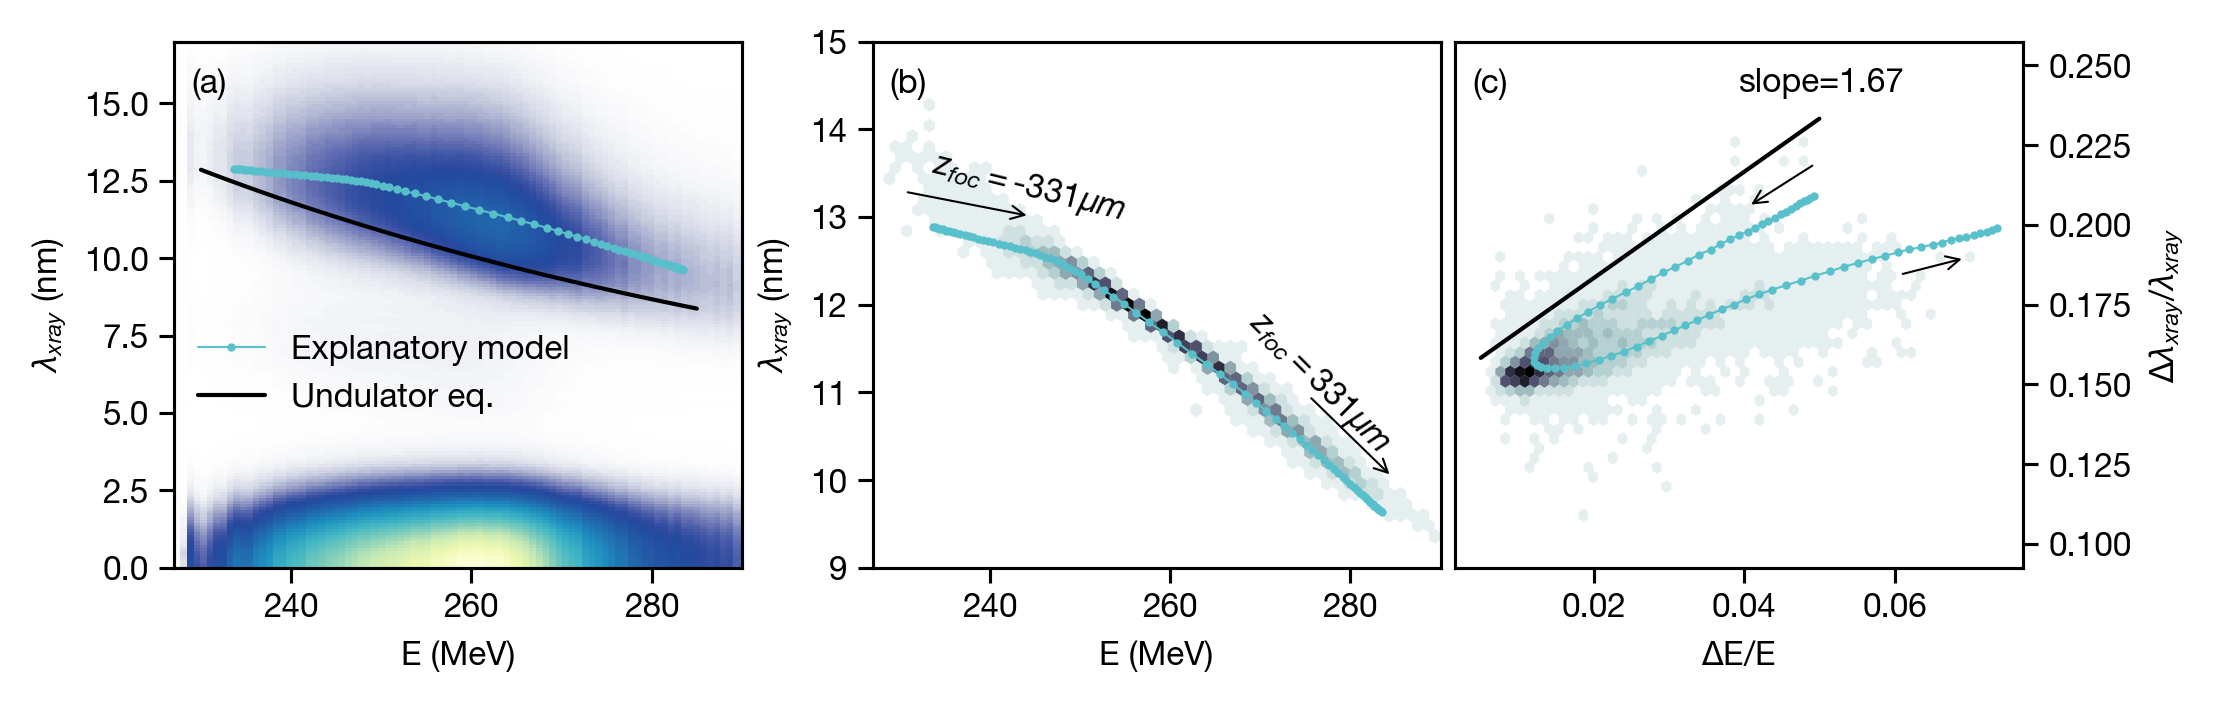

In [172]:
fig_w = figsize['inch']['double_column_width']
fig,axs = plt.subplots(1,3, figsize=(fig_w,fig_w*0.3))
ax=axs[[0,1,2]]
color = colors_preset[1]

#z[10:-10,0] = z[10:-10,0] + 20

extent = [227,290,0,17]
ax[0].plot(z[10:-10,0].flatten(),z[10:-10,-2].flatten(),'.-',lw=0.5,mew=0,ms=4,color=color,label='Explanatory model')
ax[0].pcolormesh(wfp['E'],wfp['wl'],wfp['wfp'].T,cmap=mymap)


ax[0].set_xlim(extent[0:2])
ax[0].set_ylim(extent[-2:])
ax[0].set_xlabel('E (MeV)')
ax[0].set_ylabel(r'$\lambda_{xray}$ (nm)')

extent = [227,290,9,15]
ax[1].plot(z[10:-10,0].flatten(),z[10:-10,-2].flatten(),'.-',lw=0.5,mew=0,ms=4,color=color,label='Explanatory model')
ax[1].hexbin(ydata[:,0].flatten(),ydata[:,-2].flatten(),extent=extent,bins=15,cmap = 'bone_r',
             lw=0.05,gridsize=[50,int(50*2./4)]);


ax[1].set_xlim(extent[0:2])
ax[1].set_ylim(extent[-2:])
ax[1].set_xlabel('E (MeV)')
ax[1].set_ylabel(r'$\lambda_{xray}$ (nm)')


extent = [0.005,0.07,0.1,0.25]#[1,20,1.4,3]
ax[2].plot(z[10:-10,1].flatten()/z[10:-10,0].flatten(),z[10:-10,-1].flatten()/z[10:-10,-2].flatten(),'.-',lw=0.5,mew=0,ms=4,color=color,label='Infered model')
ax[2].hexbin(ydata[:,1].flatten()/ydata[:,0].flatten(),ydata[:,-1].flatten()/ydata[:,-2].flatten(),extent=extent,bins=15,
             cmap = 'bone_r',lw=0.05,gridsize=[50,int(50*2./4)]);
#ax[1].set_xlim(extent[0:2])
#ax[1].set_ylim(extent[-2:])
ax[2].set_xlabel(r'$\Delta$E/E ')
ax[2].set_ylabel(r'$\Delta\lambda_{xray}/\lambda_{xray}$')
ax[2].yaxis.tick_right()
ax[2].yaxis.set_label_position("right")

wl_u = 5e6 # nm
K = 0.29 #0.29 # unitless
mec2 = 0.511 #MeV 

def xray_wl(E):
    return (wl_u*mec2**2/(2*(E)**2))*(1+K**2/2) #+ (np.pi*2e-7)*(E)**2/(mec2)**2)




E = np.linspace(230,285)
xwl = xray_wl(E)
ax[0].plot(E,xwl,'k',label='Undulator eq.')


dE = np.linspace(0.005,0.05)
ax[2].plot(dE,dE*2/1.2+0.15,'k',label='Undulator eq.')

ax[0].legend(frameon=False,loc='upper right', bbox_to_anchor=(0.75, 0.5))
#ax[1].text(0.55, 0.95, r'$z_{foc}=$'+f'{int(x[10])}'+r'$\mu m$', transform=ax[1].transAxes,verticalalignment='top')
#ax[1].text(0.55, 0.3, r'$z_{foc}=$'+f'{int(x[-10])}'+r'$\mu m$', transform=ax[1].transAxes,verticalalignment='top')

ax[1].text(0.65, 0.5, r'$z_{foc}=$'+f'{int(x[-10])}'+r'$\mu m$', transform=ax[1].transAxes,verticalalignment='top',rotation=-45)
ax[1].text(0.1, 0.8, r'$z_{foc}=$'+f'{int(x[10])}'+r'$\mu m$', transform=ax[1].transAxes,verticalalignment='top',rotation=-14)

ax[0].text(0.03, 0.95, r'(a)', transform=ax[0].transAxes,verticalalignment='top')
#ax[1].text(0.03, 0.95, r'(c)', transform=ax[1].transAxes,verticalalignment='top')
ax[1].text(0.03, 0.95, r'(b)', transform=ax[1].transAxes,verticalalignment='top')
ax[2].text(0.03, 0.95, r'(c)', transform=ax[2].transAxes,verticalalignment='top')
ax[2].text(0.5, 0.95, f'slope={2/1.2:0.3}', transform=ax[2].transAxes,verticalalignment='top')


ax[1].annotate("", xy=(285,10), xytext=(275,11),
            arrowprops=dict(arrowstyle="->",linewidth=0.5))
ax[1].annotate("", xytext=(230,13.3), xy=(245,13),
            arrowprops=dict(arrowstyle="->",linewidth=0.5))

ax[2].annotate("", xy=(0.04,0.205), xytext=(0.05,0.22),
            arrowprops=dict(arrowstyle="->",linewidth=0.5))
ax[2].annotate("", xytext=(0.06,0.184), xy=(0.07,0.190),
            arrowprops=dict(arrowstyle="->",linewidth=0.5))



plt.savefig('figures/corr_electron-xrays.png',dpi=300,)#bbox='tight')

In [ ]:
def bw(E,dE):
    lu = 5e-3
    K = 0.29
    alpha = (lu/2)*(1+K**2/2)
    gamma2 = (E/0.511+1)**2
    l_shift = 2e-9
    C = l_shift*gamma2/alpha
    print(C,alpha)
    return (2/(1+C))*dE/E


E = z[10:-10,0].flatten()
dE = z[10:-10,1].flatten() #np.linspace(0.005,0.05,80)
dl_l = bw(E,dE)

ax[2].plot(dE/E,dl_l)

In [82]:
1e-3*5*(1+0.29**2/2)/2

0.002605125

In [173]:
(260/0.5+1)**2

271441.0

In [102]:
138650160.74084738*2.e-9

0.27730032148169476

In [162]:
2/(1.2*1.1)

1.5151515151515151

In [151]:
z[10:-10,1].flatten()

array([17.20728451, 17.05704613, 16.91312925, 16.73395091, 16.57153874,
       16.34949292, 16.15774092, 15.91295027, 15.65855357, 15.39984901,
       15.05646458, 14.72097522, 14.38581963, 14.02923224, 13.63919417,
       13.2299155 , 12.81455384, 12.38132489, 11.94294813, 11.51030246,
       11.06408605, 10.62706122, 10.24545225,  9.85565365,  9.4725223 ,
        9.08793599,  8.69796305,  8.32067719,  7.95434442,  7.58551277,
        7.20640042,  6.81187997,  6.41173667,  6.0042847 ,  5.59409755,
        5.2013514 ,  4.80648203,  4.45003877,  4.11076552,  3.82212876,
        3.57350691,  3.38289069,  3.24045146,  3.17658252,  3.18988787,
        3.2431566 ,  3.37115324,  3.56734483,  3.81934131,  4.11215827,
        4.46486042,  4.85035997,  5.27487814,  5.72270274,  6.18916111,
        6.68236526,  7.17053931,  7.65315313,  8.1275002 ,  8.58550915,
        9.05729123,  9.4800525 ,  9.9325376 , 10.30518279, 10.68719325,
       11.03092377, 11.36911081, 11.65633537, 11.9409533 , 12.17

In [160]:
np.sqrt((260/10/128)**2+(2/1.25)**2)

1.612842139090184

In [158]:
2/1.25

1.6

In [174]:
2/1.2

1.6666666666666667

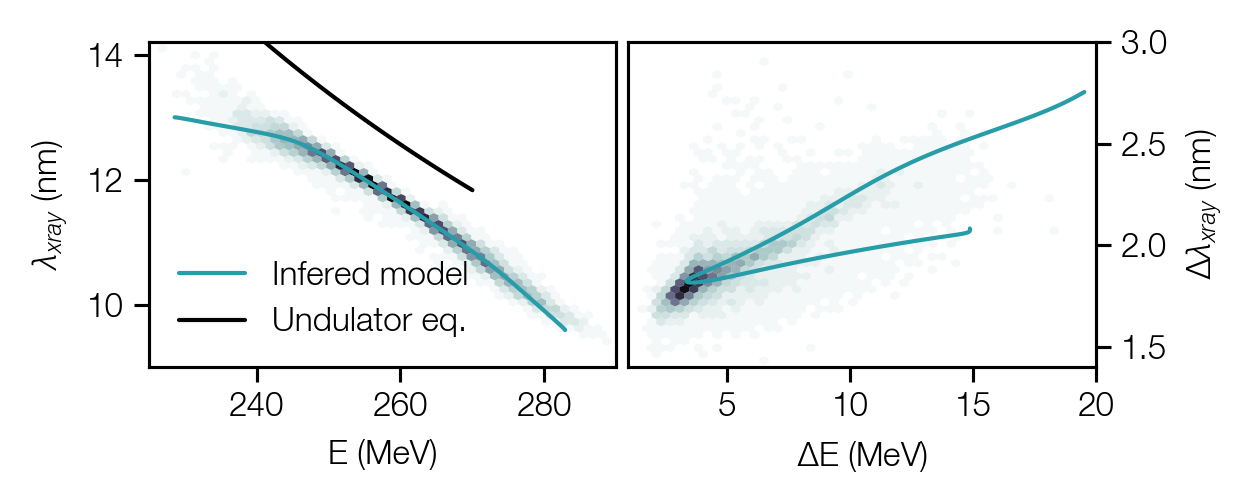

In [416]:

fig,ax = plt.subplots(1,2, figsize=(4,1.5))
extent = [225,290,9,14.2]
ax[0].plot(z[50,:,0].flatten(),z[50,:,-2].flatten(),color=color,label='Infered model')
ax[0].hexbin(trainset.y[:,0].numpy().flatten(),trainset.y[:,-2].numpy().flatten(),extent=extent,bins=30,cmap = 'bone_r',
             lw=0.05,gridsize=[50,int(50*2./4)]);
ax[0].set_xlim(extent[0:2])
ax[0].set_ylim(extent[-2:])
ax[0].set_xlabel('E (MeV)')
ax[0].set_ylabel('$\lambda_{xray}$ (nm)')

extent = [1,20,1.4,3]
ax[1].plot(z[50,:,1].flatten(),z[50,:,-1].flatten(),color=color,label='Infered model')
ax[1].hexbin(trainset.y[:,1].numpy().flatten(),trainset.y[:,-1].numpy().flatten(),extent=extent,bins=30,
             cmap = 'bone_r',lw=0.05,gridsize=[50,int(50*2./4)]);
ax[1].set_xlim(extent[0:2])
ax[1].set_ylim(extent[-2:])
ax[1].set_xlabel('$\Delta$E (MeV)')
ax[1].set_ylabel('$\Delta\lambda_{xray}$ (nm)')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")

wl_u = 5e6 # nm
K = 0.29 #0.29 # unitless
mec2 = 0.511 #MeV 

def xray_wl(E,theta=10e-4):
    return (wl_u*mec2**2/(2*(E)**2))*(1 + K**2/2 + theta**2*E**2/mec2**2) #+ (np.pi*2e-7)*(E)**2/(mec2)**2)

E = np.linspace(230,270)
xwl = xray_wl(E)
ax[0].plot(E,xwl,'k',label='Undulator eq.')
ax[0].legend(frameon=False)

#plt.savefig('figures/corr_electron-xrays.png',dpi=300,bbox='tight')